# Continuous Control - Reacher multi

## Train the agent ##
---

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='Reacher_multi.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents  :', num_agents)
action_size = brain.vector_action_space_size
print('Action space      :', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print("State size        :", state_size)
print('State description :', states[0])

Number of agents  : 20
Action space      : 4
State size        : 33
State description : [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


When finished, you can close the environment.

In [4]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)  

In [5]:
import sys
sys.path.insert(0, './code/')
from ddptagent import Agent

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [7]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import torch

In [8]:
def show_graph(lq, avgs, mavgs, title="Training history"):
    plt.figure(figsize=(10,8))
    plt.plot(lq, ".", label="min")
    plt.plot(avgs, c="r", label="max")

    plt.plot(mavgs, c="g", label="mean")
        
    plt.axhline(y=30, color='m', linestyle='-.')
    plt.title(title)
    plt.legend()
    plt.show()

In [9]:
#def ddpg(n_episodes=500, max_t=1000, target_score=30.0, target_episodes=100, print_every=1, train_mode=True,
#         actor_path='actor_chk.pt', critic_path='critic_chk.pt'):


In [10]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)

In [11]:
actor_path = "actor_chk.pt"
critic_path= "critic_chk.pt"

In [12]:
def ddpg(n_episodes=500, max_t=1000, target_score=30.0, target_episodes=100, print_every=1, train_mode=True,
         actor_path='actor_chk.pt', critic_path='critic_chk.pt'):
    
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train (bool)          : Train mode true or false
        target_score (float)  : min avg score over consecutive episodes
        target_episodes (int) : number of consecutive episodes used to calculate the score
        print_every (int)     : interval to display results
        actor_path (str)      : directory to store actor's weights
        critic_path (str)     : directory to store critic's weights

    """
    means = []                                # list to save mean scores
    min_s = []                                # list of lowests scores of each episode
    max_s = []                                # list of highest scores of each episode
    best_score = -1e10
    scoresDQ   = deque(maxlen=target_episodes)    # mean scores of n most recent episodes (n=target_episodes)
    mavs = []                                 # list of moving averages
    
    episode_ist = 1
    while True:
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        agents_score = np.zeros(num_agents)                     # initialize score for each agent
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select an action for agents
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next states for agents
            rewards = env_info.rewards                          # get the rewards
            dones = env_info.local_done                         # see if episode has finished
            
            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            agents_score += rewards    
            if np.any(dones):                                   # breaks when any agent ends its episode
                break

        min_s.append(np.min(agents_score))
        max_s.append(np.max(agents_score))
        means.append(np.mean(agents_score))           
        scoresDQ.append(np.mean(agents_score))
        
        mavs.append(np.mean(scoresDQ))
        
        clear_output(wait=True)
        show_graph(min_s, max_s, mavs)
        print("Episode", episode_ist, "score mean", means[-1], "average on deque", np.average(scoresDQ))
        print(len(scoresDQ), np.mean(agents_score), target_score, target_episodes)
        
        if train_mode and means[-1] > best_score:
            torch.save(agent.actor_local.state_dict(), actor_path)
            torch.save(agent.critic_local.state_dict(), critic_path)
                  
        if np.average(scoresDQ) >= target_score and len(scoresDQ) >= target_episodes:
            print("Environment SOLVED in " + str(episode_ist) + "episodes")
            print("Moving Average = " + str(mavs[-1]) + " over last " + str(target_episodes) + " episodes")
                  
            if train_mode:
                torch.save(agent.actor_local.state_dict(), actor_path)
                torch.save(agent.critic_local.state_dict(), critic_path)  
            break
        episode_ist+=1    
    return means, mavs

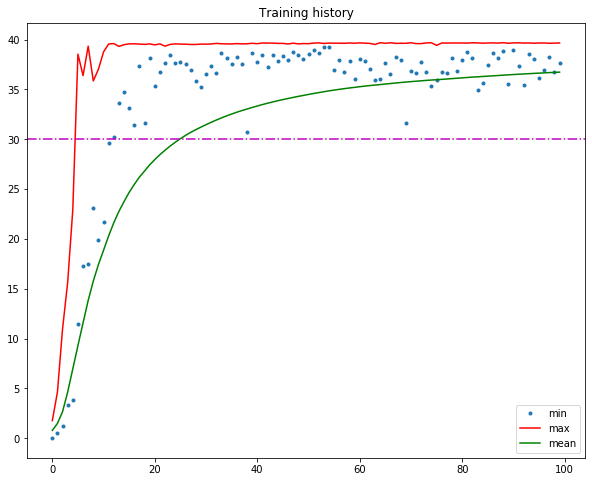

Episode 100 score mean 39.20949912359938 average on deque 36.73691917886585
100 39.20949912359938 30.0 100
Environment SOLVED in 100episodes
Moving Average = 36.73691917886585 over last 100 episodes


In [13]:
scores, avgs = ddpg(actor_path=actor_path, critic_path=critic_path, max_t=1000, target_episodes=100, target_score=30.0)


In [14]:
env.close()